In [1]:
import os
import sys

import re
import time
import pickle

import pandas as pd
import numpy as np
from IPython.display import Image, display
import glob

from gensim import corpora, models, similarities
from gensim.test.utils import get_tmpfile


In [2]:
work_dir = '/media/hdd1/bsong/image_text'

list_paths = glob.glob(work_dir + '/flickr30k_images'+ '/*')
list_names = map(lambda x: x.replace(work_dir + '/flickr30k_images/',''), list_paths)
print(list_names[:5])

captions_raw = []
with open(work_dir + '/results_20130124.token','r') as cap_text:
    for line in cap_text:
        captions_raw.append(line)



['4898846532.jpg', '5338568818.jpg', '2375402652.jpg', '6400126225.jpg', '97748313.jpg']


In [3]:
if not os.path.exists(work_dir + '/model_files'):
    os.makedirs(work_dir + '/model_files')

In [4]:
def preprocess_text(text):

    def remove_special_char(text):
        special_char = ['.',',','=','-','_','?','!',';',':',"'",'"','(',')','*','&','^','%','$','#','@','~','`','+','/','\\'] #,'?','!',';',':',"'",'"' temporarily added
        for i in special_char:
            text = text.replace(i,'')
        return text
    text = re.sub('/',' ', text) # sometimes people write like 'cleaning/detailing', so replace / with space
    text = remove_special_char(text)
    text = text.lower()
      
    return text

In [5]:
def f7_tup(seq):
    seen = set()
    seen_add = seen.add
    return [x for x in seq if not (x[0] in seen or seen_add(x[0]))]

def f7(seq):
    seen = set()
    seen_add = seen.add
    return [x for x in seq if not (x in seen or seen_add(x))]

class similarity:
    def __init__(self, dict_, tfidf, lsi, cos_index, ind2img, tuple_pic_cap):
        self.dict_ = dict_
        self.tfidf = tfidf
        self.lsi = lsi        
        self.cos_index = cos_index
        self.ind2img = ind2img
        self.tuple_pic_cap = tuple_pic_cap
        
    def get_simil(self, test_string):
        test_string = preprocess_text(test_string).split()
        conv_str = self.lsi[self.tfidf[self.dict_.doc2bow(test_string)]]
        sims = self.cos_index.__getitem__(conv_str)
        if sims == []:
            print('no matches found')
            return None
        else:
            captions = map(lambda x: tuple_pic_cap[x[0]][1], sims)
            sims = map(lambda x: tuple([self.ind2img[x[0]], x[1]]), sims)
            sims = f7_tup(sims)
            return sims, captions
            
def print_results(test_string, dummy, df):
    results, captions = dummy.get_simil(test_string)

    for i in range(5):
        one_result = results[i]
        jpgname = one_result[0]
        sim_score = one_result[1]
        caption = df[df.img == jpgname].caption.values
        caption = '\n'.join(caption)
        print('IMAGE #' + str(i))
        display(Image(filename=work_dir + '/flickr30k_images/' + jpgname)) 
        print('picture caption: \n' + str(caption))
        #print('similarity score: ' + str(sim_score))
        print(' ')

In [6]:
captions_raw = map(lambda x: x.replace('\n',''), captions_raw)
print('IMAGE AND CAPTION \n')
print('\n'.join(captions_raw[:5]))

print('\nEACH ROW AS TUPLE \n')
tuple_pic_cap = map(lambda x: x.split('\t'), captions_raw)
tuple_pic_cap = map(lambda x: tuple([x[0].split('#')[0], x[1]]), tuple_pic_cap)
print('\n'.join(map(lambda x: '{}'.format(x), tuple_pic_cap[:5])))

tuple_pic_cap = map(lambda x: tuple([x[0], preprocess_text(x[1])]), tuple_pic_cap)
print('\nPREPROCESS TEXT \n')
print('\n'.join(map(lambda x: '{}'.format(x), tuple_pic_cap[:5])))


IMAGE AND CAPTION 

1000092795.jpg#0	Two young guys with shaggy hair look at their hands while hanging out in the yard .
1000092795.jpg#1	Two young , White males are outside near many bushes .
1000092795.jpg#2	Two men in green shirts are standing in a yard .
1000092795.jpg#3	A man in a blue shirt standing in a garden .
1000092795.jpg#4	Two friends enjoy time spent together .

EACH ROW AS TUPLE 

('1000092795.jpg', 'Two young guys with shaggy hair look at their hands while hanging out in the yard .')
('1000092795.jpg', 'Two young , White males are outside near many bushes .')
('1000092795.jpg', 'Two men in green shirts are standing in a yard .')
('1000092795.jpg', 'A man in a blue shirt standing in a garden .')
('1000092795.jpg', 'Two friends enjoy time spent together .')

PREPROCESS TEXT 

('1000092795.jpg', 'two young guys with shaggy hair look at their hands while hanging out in the yard ')
('1000092795.jpg', 'two young  white males are outside near many bushes ')
('1000092795.jpg', 

In [7]:
## make dataframe to easily join caption text per jpg

df = pd.DataFrame(tuple_pic_cap, columns=['img','caption'])
list_img = f7(list(df.img.values))
print(df.shape, len(list_img))
tuple_pic_cap = map(lambda x: (x,' '.join(list(df[df.img == x].caption.values))), list_img)

((158915, 2), 31783)


In [8]:
# make a dictionary to map cosine similarity matrix row index to the associated jpg file name

ind2img = dict(zip(range(len(tuple_pic_cap)), map(lambda(x): x[0], tuple_pic_cap)))

In [9]:
def string_as_gen(tup, type_, dict_ = dict(), tfidf = dict(), lsi = dict()):
    '''
    Store all the string as a generator with string split by space.
    
    Generators help keep the memory usage low (which increases unnecessarily when having a list of lists)
    '''
    if type_ == 'dict':
        for i in tup:
            yield i[1].split()
    elif type_ == 'tfidf':
        for i in tup:
            yield dict_.doc2bow(i[1].split())
    elif type_ == 'lsi':
        for i in tup:
            yield tfidf[dict_.doc2bow(i[1].split())]
    elif type_ == 'full':
        for i in tup:
            yield lsi[tfidf[dict_.doc2bow(i[1].split())]]
            

## build gensim dictionary

len_list = len(tuple_pic_cap)
text_for_dict = string_as_gen(tuple_pic_cap, 'dict')
dictionary_ = corpora.Dictionary()
for _ in range(len_list):
    dictionary_.add_documents([text_for_dict.next()])

dictionary_.filter_extremes(no_below = 4, no_above = .9, keep_n = 1000000)


In [10]:
## filter stop words

from nltk.corpus import stopwords
stopword_set = set(stopwords.words('english'))
stopword_set = map(preprocess_text, stopword_set)

dictionary_.filter_tokens(bad_ids = stopword_set)

In [11]:
## save somewhere
dictionary_.save(work_dir + '/model_files/gensim_dict.dict')

In [12]:
## build tfidf model

text_for_tfidf = string_as_gen(tuple_pic_cap ,'tfidf', dictionary_)
tfidf = models.TfidfModel(text_for_tfidf)

In [13]:
## build lsi model
n_topics = 150
text_for_lsi = string_as_gen(tuple_pic_cap, 'lsi', dictionary_, tfidf)
lsi = models.LsiModel(text_for_lsi, id2word = dictionary_, num_topics = n_topics)

## build cosine similarity matrix
text_for_cos = string_as_gen(tuple_pic_cap, 'full', dictionary_, tfidf, lsi)
temp_file = get_tmpfile(work_dir + '/model_files/shard')
cos_index = similarities.Similarity(temp_file, text_for_cos, num_features = n_topics, num_best = 100, shardsize=48000)



In [14]:
## Use wrapper class to cleanly output things

dummy = similarity(dictionary_, tfidf, lsi, cos_index, ind2img, tuple_pic_cap)

IMAGE #0


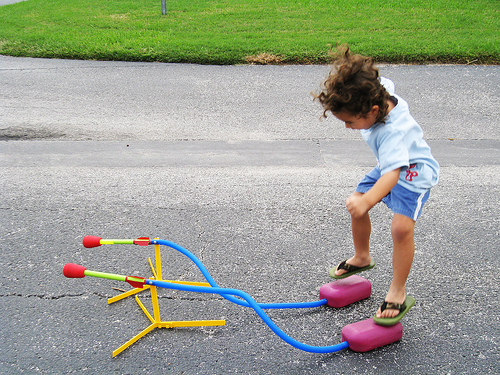

picture caption: 
a little girl is playing with a colorful toy in the ground 
a young girl playing with two plastic and foam toy rockets 
a small child jumps on a colorful toy in the street 
a young girl plays on a colorful toy outside 
a little boy jumps on a toy air gun 
 
IMAGE #1


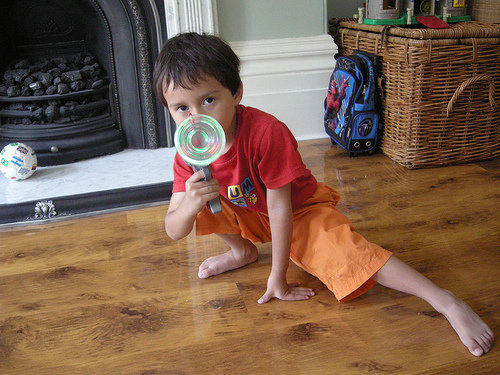

picture caption: 
a young boy with his foot outstretched aims a toy at the camera in front of a fireplace 
a little boy in orange shorts playing with a toy 
a young child plays with his new lightup toy 
boy with toy gun pointed at the camera 
a boy with a toy gun 
 
IMAGE #2


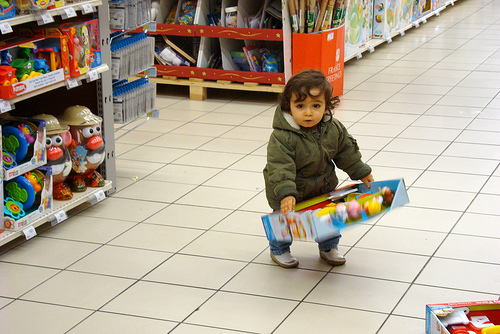

picture caption: 
a child wearing a coat is standing on a white tile floor holding a toy in a toy store 
a child wearing a dark green coat carrying a toy in a toy store 
a male toddler in a jacket carries a toy in a store 
a young child is carrying a toy in the store 
young boy holding a toy in a store 
 
IMAGE #3


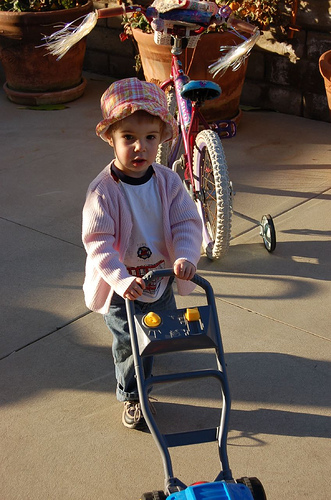

picture caption: 
a young girl in a cute hat and pink sweater pushes a toy lawn mower in front of a bicycle 
a female toddler pushing a toy lawn mower 
a little girl pushing her toy lawn mower 
a kid is walking and he is pushing his toy
a toddler pushing a toy lawn mower 
 
IMAGE #4


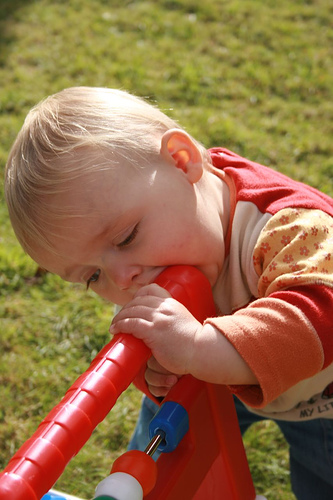

picture caption: 
a blond toddler placing his mouth on the edge of a red plastic toy 
a baby is trying to eat a large red plastic toy outdoors 
a child with his mouth on a red plastic toy 
a child plays with a toy in the grass 
a blond infant chewing on a red toy 
 


In [15]:
## testing block to play with

test_string = 'kid with a toy'

print_results(test_string, dummy = dummy, df = df)